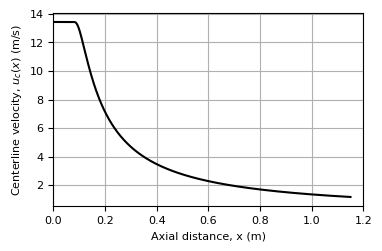

Time taken to reach sensors: 0.48778 s
tau (s): 0.02603 s
xm 0.07539370349250518
tau using eq (9) Karcher 2015: 0.00561 s
Gtest: 3.41111 
7.6963058844926096
0.07367367367367367


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf
plt.rcParams['font.size']   = 8
# Given conditions
rhoj = 18753.74 / (297 * (273.14 + 90))
rhoe = 18753.74 / (297 * (273.14 - 48))
p_e = rhoe / rhoj

r = 0.009  # nozzle radius (m)
uExit = 13.43  # exit velocity (m/s)

# Thermodynamic constants
gamma = 1.4
R = 297
Tj = 273.14 + 90  # stagnation temperature at exit in K

# Exit Mach number
a_exit = np.sqrt(gamma * R * Tj)
Mj = uExit / a_exit

# Eddy-viscosity constant for subsonic
K = 0.08 * (1 - 0.16 * Mj) * p_e**(-0.22)
kappa = K

# Non-dimensional potential-core length
Xc = 0.70

# Axial distances
x = np.linspace(0, 1.15, 1000)
x_m = np.linspace(0, 0.25, 1000)

bar_x = x / r
bar_x_m = x_m / r

# Threshold for potential core (bar_x threshold)
bar_x_thresh = Xc / (kappa * np.sqrt(p_e))

# Compute normalized centerline velocity
u_bar = np.empty_like(bar_x)
u_bar_m = np.empty_like(bar_x_m)
# Inside potential core: velocity equals exit velocity
u_bar[bar_x <= bar_x_thresh] = 1.0
u_bar_m[bar_x_m <= bar_x_thresh] = 1.0
# Beyond potential core: use the exact decay law
mask = bar_x > bar_x_thresh
mask_m = bar_x_m > bar_x_thresh

denominator = kappa * bar_x[mask] * np.sqrt(p_e) - Xc
denominator_m = kappa * bar_x_m[mask_m] * np.sqrt(p_e) - Xc

u_bar[mask] = 1 - np.exp(-1 / denominator)
u_bar_m[mask_m] = 1 - np.exp(-1 / denominator_m)

# Compute dimensional centerline velocity
u_c = uExit * u_bar
u_c_m = uExit * u_bar_m

# Plot

fig, ax = plt.subplots(figsize = (4, 2.5))
ax.plot(x, u_c, c='k')
ax.set_xlim(0, 1.2)
ax.set_xlabel('Axial distance, x (m)')
ax.set_ylabel('Centerline velocity, $u_c(x)$ (m/s)')
ax.grid()

plt.show()
t_sens = np.trapezoid(u_c**(-1), x)
tau = np.trapezoid(u_c_m**(-1), x_m)
print(f"Time taken to reach sensors: {t_sens:.5f} s")
print(f"tau (s): {tau:.5f} s")

# tau using eq (9) Karcher 2015
xm = 0.009 * np.sqrt(2/0.0285)
print("xm", xm)
tau_eq9 = xm / uExit
print(f"tau using eq (9) Karcher 2015: {tau_eq9:.5f} s") 

Gtest = ( 475.73 - Tf.p_sat_ice_murphy_koop(225.15)) / (363.14 - 225.15) 
print(f"Gtest: {Gtest:.5f} ")
print(bar_x_thresh)
print(x[64])

fig.savefig('Jet_vel_decay.png', dpi=400, bbox_inches='tight')


In [17]:
from numpy.typing import ArrayLike
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf


"""
Input Parameters for the model
------------------------------
"""

# Ambient & initial plume conditions
Ta = 226.15            # Ambient temperature (K)
pa = 18754         # Ambient total pressure (Pa)
Ti = 363.15            # Initial temperature of the plume (K)
pwa = Tf.p_sat_ice_murphy_koop(Ta) # Ambient water vapor pressure (Pa)
nAmbient = 600 * 10**6 # Ambient number concentration of aerosols (/m^3)

# Engine (and Mixing Line) Parameters 
N0 = 61.7             # Air to fuel 
nsoot = 4.4736 * 10**12 # Number concentration of soot in the plume at the exhaust (/m^3)
G = 3.411                # Mixing line slope (Pa/K)
tau = 0.00561          # Characteristic mixing timescale (s)
#tau = 0.033625

# Aerosol properties
sigmaSoot = 1.7     # Standard deviation of a log-normal distribution for soot
sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
kSoot = 0.005       # Solubility parameter for soot
kAmbient = 0.5      # Solubility parameter for ambient aerosols
rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
rMeanSoot = 2.359 * 10**-9 # Mean dry soot radius (m)
rMeanAmbient = 14 * 10**-9 # Mean dry Ambient aerosol radius (m)
# Model resolution 
n = 100000          # Number of points in the model

"""
Model Calculations
------------------------------
"""
# Temperature and time
T = np.geomspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
rho = pa/(287 * T)                              # Density of the plume as a function of temperature (kg/m^3)
                                                # Note we assume isobaric expansion
time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

# Thermodynamic parameters
pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation (at liquid saturation) vapor pressure of water (Pa)
piSat = Tf.p_sat_ice_murphy_koop(T)            # Saturation (at ice saturation) vapor pressure of water (Pa)
niSat = Tf.number_concentration_sat_ice(T)     # Number concentration of H20 at ice saturation as a function of temperature (m^-3)
nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)

# Mixing line parameters
Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line

Smi = Mf.saturation_ratio_mixing_line_ice(T, Ta, G, pwa) # Saturation ratio of the plume along the mixing line with respect to ice
smi = Smi - 1  
                                        # Supersaturation ratio of the plume along the mixing line with respect to ice
dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)

# Particle distribution parameters
EIsoot = (N0 * nsoot) / (pa/(363.15 * 287)) # Apparent emission index of soot particles (/kg of fuel burned)
print(f"EIsoot * 10^15: {EIsoot * 10**-15:.5f}")
zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols
rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsoot, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

# Microphysical parameters - determines radius and number concentration at water saturation
nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

dSdt = Mf.supersaturation_forcing2(T, dTdt, Smw) # Supersaturation forcing term in the microphysical model

tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

# Determine Final Results at Water Saturation:
# - Pressure    - Float
# - RH(ambient) - Float     - pwa / pwSat(Ta)
# - RHi(ambient)- Float     - pwa / picesat(Ta)
# - Ta          - Float
# - Theta - T   - Float     - Need to find Phi
# - Phi         - Float     - Need to find Phi
# - ni          - Float     - intersection of nw1 and nw2
# - to          - Float     - time of intersection
# - ri          - Float     - ro at intersection
# - OD          - Float     - Optical depth at intersection -> Not calculated atm


# Clean up the data 
valid_indices = (smw >= 0)

timeV = time[valid_indices]
TV = T[valid_indices]


smwV = smw[valid_indices]
nw1V = nw1[valid_indices]
nw2V = nw2[valid_indices]
roV = ro[valid_indices]
rhoV = rho[valid_indices]
DilutionV = Dilution[valid_indices]

nwSootV = nwSoot[valid_indices]
nwAmbientV = nwAmbient[valid_indices]
psiSootV = psiSoot[valid_indices]
psiAmbientV = psiAmbient[valid_indices]

intercept = abs(nw1V - nw2V)
index2 = np.where(intercept == np.min(intercept))[0][0]  # Find the index of the minimum difference

ro_intercept = roV[index2]
time_intercept = timeV[index2]
nw_intercept = nw1V[index2]
T_intercept = TV[index2]

nwSoot_intercept = nwSootV[index2]
nwAmbient_intercept = nwAmbientV[index2]
psiSoot_intercept = psiSootV[index2]
psiAmbient_intercept = psiAmbientV[index2]
Dilution_intercept = DilutionV[index2]
rho_intercept = rhoV[index2]

Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercept, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)

Tfrz = Mpf.Temp_frz(dTdt, ro_intercept, rMeanSoot)
TfrzIntercept = np.abs(T - Tfrz).argmin()  # Find the index of the minimum difference
TfrzValue = T[TfrzIntercept]
timeFrz = time[TfrzIntercept]


print(f"RHi: {RHi}")
print(f"Ta: {Ta}")
print(f"thetaRH - Ta: {thetaRH - Ta}")
print(f"Phi: {Phi}")
print(f"no (/m^3) * 10^12: {(nw_intercept * 10**-12) }")
print(f"to: {time_intercept}")
print(f"ro (micrometres): {ro_intercept * 10**6}")
print(f"T*: {TfrzValue}")
print(f"t*: {timeFrz:.5f} s")

tFinal = 0.48778


tFinalIndex = np.abs(time - tFinal).argmin()  # Find the index of the minimum difference
rhoFinal = rho[tFinalIndex]
DilutionFinal = Dilution[tFinalIndex]

niFinal = (nw_intercept * rhoFinal * DilutionFinal) / (rho_intercept * Dilution_intercept)
print(f"niFinal (/m^3) *10^12: {niFinal * 10**-12:.5f}") 

print(f"d: {0.018/np.sqrt(DilutionFinal)}")


EIsoot * 10^15: 1.53397
RHi: 1.0
Ta: 226.15
thetaRH - Ta: 4.500969282734388
Phi: 0.2579620350324667
no (/m^3) * 10^12: 0.19928265201543907
to: 0.06206175918974696
ro (micrometres): 0.23532224780468614
T*: 227.56935415222134
t*: 0.89972 s
niFinal (/m^3) *10^12: 0.03298
d: 0.13424813975756056


c:\Users\Gorak\OneDrive - Imperial College London\Mech Eng\ME4\FYP\Technical\Model_development\Jet_regime_microphys\Kacher2015_model\Microphysical_funcs.py:121: RuntimeWarning: divide by zero encountered in divide
  return (3 * sw) / (2 * avgZeta * dSdt)
c:\Users\Gorak\OneDrive - Imperial College London\Mech Eng\ME4\FYP\Technical\Model_development\Jet_regime_microphys\Kacher2015_model\Microphysical_funcs.py:192: RuntimeWarning: invalid value encountered in add
  (1 + 2 * kw + 2 * kw**2))/(volH2O * nwSaturation)
